# How to Develop Convolutional Neural Network Models for Time Series Forecasting
four parts:

1. Univariate CNN Models
2. Multivariate CNN Models
3. Multi-Step CNN Models
4. Multivariate Multi-Step CNN Models

# CNN Model
A one-dimensional CNN is a CNN model that has a convolutional hidden layer that operates over a 1D sequence (Conv1D). This is followed by perhaps a second convolutional layer in some cases, such as very long input sequences, and then a pooling layer whose job it is to distill the output of the convolutional layer to the most salient elements.

The convolutional and pooling layers are followed by a dense fully connected layer that interprets the features extracted by the convolutional part of the model. A flatten layer is used between the convolutional layers and the dense layer to reduce the feature maps to a single one-dimensional vector.

# 1. Univariate CNN Models
Although traditionally developed for two-dimensional image data, CNNs can be used to model univariate time series forecasting problems.

Univariate time series are datasets comprised of a single series of observations with a temporal ordering and a model is required to learn from the series of past observations to predict the next value in the sequence.

(6, 3) (6,)


2022-02-24 12:01:14.073811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 12:01:14.148552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 12:01:14.148739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 12:01:14.149857: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

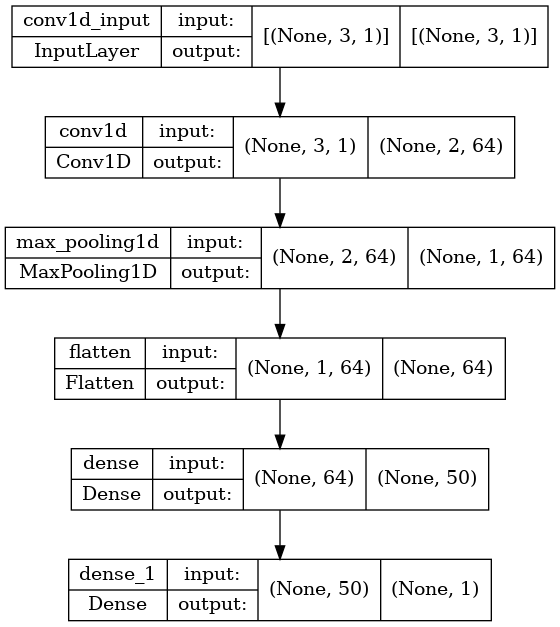

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import plot_model
import numpy as np


# define 1D CNN model
def cnn_model(X, y, n_steps, n_features):
    model = Sequential()
    # define input layer 1D CNN
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    # interpreting pooling layer distill the output to the most salient elements.
    # pool size equals to number of feature in a time series (=2)
    model.add(MaxPooling1D(pool_size=2))
    # flatten layer reduces the feature maps to a single 1D vector.
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1)) # output layer
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=1000, verbose=0)
    
    return model

# prepare data
def split_uni_seq(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end = i + n_steps
        if end > len(sequences) - 1:
            break
        seq_x, seq_y = sequences[i:end], sequences[end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
n_features = 1
X, y = split_uni_seq(raw_seq, n_steps)
print(X.shape, y.shape)
model = cnn_model(X, y, n_steps, n_features)
plot_model(model, show_shapes=True)

In [2]:
# reshape from [samples, timesteps] into [samples, timesteps, features]

X = X.reshape((X.shape[0], X.shape[1], n_features))

# demonstrate prediction
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.07656]]


# 2. Multivariate CNN models
Multivariate time series data means where there is more than one observation for each time step.

## 2.1. Multiple Input series
Two or more parallel input time series and an output time series that is dependant on the input time series.

The input time series are parallel because each series has observations at the same time step.

Parallel input:

    10, 15
    20, 25
    30, 35
    
Output: 65

That is, the first three time steps of each parallel series are provided as input to the model and the model associates this with the value in the output series at the third time step, in this case, 65.

In [3]:
## define parallel time series dataset
def define_parallel(seq1, seq2, n_features):
    seq1 = np.array(seq1)
    seq2 = np.array(seq2)
    out_seq = np.array([seq1[i] + seq2[i] for i in range(len(seq1))])
    # convert to [rows, columns] structure
    seq1 = seq1.reshape((len(seq1), n_features))
    seq2 = seq2.reshape((len(seq2), n_features))
    out_seq = out_seq.reshape((len(out_seq), n_features))
    # combine into 1 sequence with horizontal structure
    return np.hstack((seq1, seq2, out_seq))

# define input sequence
in_seq1 = [10, 20, 30, 40, 50, 60, 70, 80, 90]
in_seq2 = [15, 25, 35, 45, 55, 65, 75, 85, 95]

n_features = 1
sequences = define_parallel(in_seq1, in_seq2, n_features)
sequences

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [4]:
## prepare data for model training
def split_parallel_input(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        ix = i + n_steps
        if ix > len(sequences):
            break
        seq_x = sequences[i:ix, :-1]
        seq_y = sequences[ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 3
X, y = split_parallel_input(sequences, n_steps)
print(X.shape, y.shape)

(7, 3, 2) (7,)


In [5]:
## Train with CNN model
n_features = X.shape[2] # get number features of a time series

# demonstrate prediction
x_input = np.array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
model = cnn_model(X, y, n_steps, n_features)
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[206.49002]]


## 2.1.1. Multi-headed CNN model
Each input series can be handled by a separate CNN and the output of each of these submodels can be combined before a prediction is made for the output sequence.

It may offer more flexibility or better performance depending on the specifics of the problem that is being modeled. For example, it allows you to configure each sub-model differently for each input series, such as the number of filter maps and the kernel size.

- First, we can define the first input model as a 1D CNN with an input layer that expects vectors with n_steps and 1 feature.

- Then, We define the second input submodel in the same way.

- Finally, now that both input submodels have been defined, we can merge the output from each model into one long vector which can be interpreted before making a prediction for the output sequence.

- We can then tie the inputs and outputs together.

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

## define model
def multi_headed_cnn_model(X1, X2, y, n_steps, n_features):
    # first input model
    visible1 = Input(shape=(n_steps, n_features))
    cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible1)
    cnn1 = MaxPooling1D(pool_size=2)(cnn1)
    cnn1 = Flatten()(cnn1)
    # second input model
    visible2 = Input(shape=(n_steps, n_features))
    cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible2)
    cnn2 = MaxPooling1D(pool_size=2)(cnn2)
    cnn2 = Flatten()(cnn2)
    # merge 2 input models
    merge = concatenate([cnn1, cnn2])
    dense = Dense(50, activation='relu')(merge)
    output = Dense(1)(dense)
    model = Model(inputs=[visible1, visible2], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    model.fit([X1, X2], y, epochs=1000, verbose=0)
    
    return model

## prepare dataset
# reset features
n_features = 1
X1 = X[:, :, 0].reshape((X.shape[0], X.shape[1], n_features))
X2 = X[:, :, 1].reshape((X.shape[0], X.shape[1], n_features))
print(X1.shape, X2.shape)

(7, 3, 1) (7, 3, 1)


[[207.11754]]


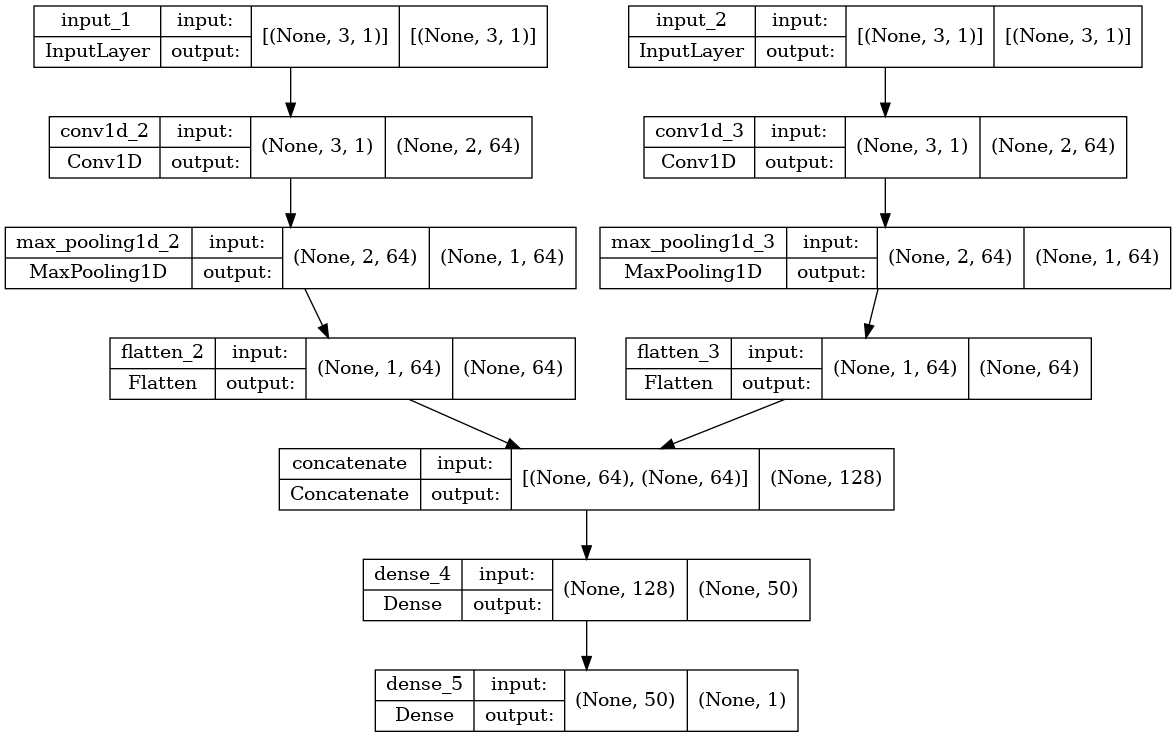

In [7]:
# demonstrate prediction
x_input = np.array([[80, 85], [90, 95], [100, 105]])
x1 = x_input[:, 0].reshape((1, n_steps, n_features))
x2 = x_input[:, 1].reshape((1, n_steps, n_features))
model = multi_headed_cnn_model(X1, X2, y, n_steps, n_features)
yhat = model.predict([x1, x2], verbose=0)
print(yhat)
plot_model(model, show_shapes=True)

## 2.2. Multiple Parallel Series
An alternate time series problem is the case where there are multiple parallel time series and a value must be predicted for each.

    [ 10  15  25]
    [ 20  25  45]
    [ 30  35  65]
    
Predict the value for each of the three time series for the next time step. Output:

    [40, 45, 85]

In [8]:
## split data into multiple parallel time series which rows for time steps and one series per columns
## each time series is a 2D array, 3 array chilren, and 3 columns for a child   
def split_multiple_parallel(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        ix = i + n_steps
        if ix > len(sequences)-1:
            break
        seqx, seqy = sequences[i:ix, :], sequences[ix, :]
        X.append(seqx)
        y.append(seqy)
    return np.array(X), np.array(y)

n_steps = 3
X, y = split_multiple_parallel(sequences, n_steps)
print(X.shape, y.shape)

(6, 3, 3) (6, 3)


In [9]:
## redefine the cnn model for multiple values as a vector
def vector_output_model(X, y, n_steps, n_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    # downsamples the input representation by taking the max value over a spatial window of size pool_size
    model.add(MaxPooling1D(pool_size=2)) 
    # if inputs are shaped (batch,) without feature axis, then flattening adds an extra channel dim (batch, 1)
    model.add(Flatten())
    model.add(Dense(50, activation='relu')) # hidden layer as input
    model.add(Dense(n_features)) # output is a vector 
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=3000, verbose=0)
    
    return model

In [10]:
n_features = X.shape[2] # get the feature value

x_input = np.array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
model = vector_output_model(X, y, n_steps, n_features)
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.08932 107.12138 208.36041]]


[[112.1776   119.235374 231.7251  ]]


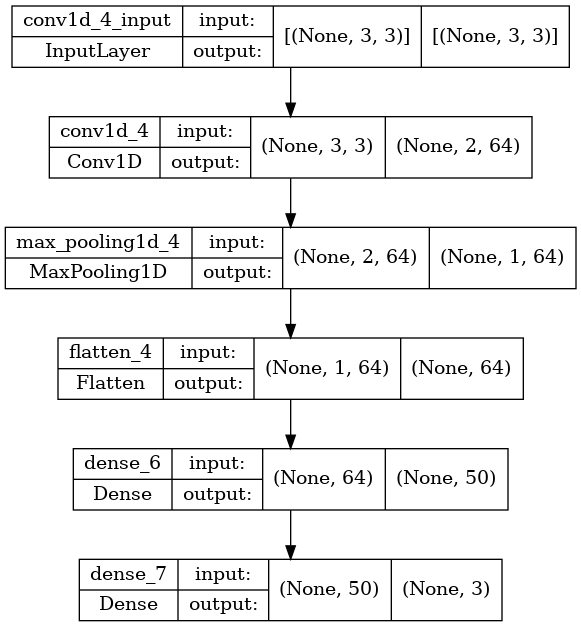

In [11]:
x_input = np.array([[80,85,165], [90,95,185], [100, 105, 205]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)
plot_model(model, show_shapes=True)

## 2.2.1 Multiple individual Output CNN model

In [12]:
## define multiple output model
def multiple_output_model(X, y, n_steps, n_features):
    # separate training output values
    y1 = y[:, 0].reshape((y.shape[0], 1))
    y2 = y[:, 1].reshape((y.shape[0], 1))
    y3 = y[:, 2].reshape((y.shape[0], 1))
    # first input 1D CNN model
    visible = Input(shape=(n_steps, n_features))
    cnn = Conv1D(filters=64, kernel_size=2, activation='relu')(visible)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)
    cnn = Dense(50, activation='relu')(cnn)
    # define multi-outputs
    output1 = Dense(1)(cnn)
    output2 = Dense(1)(cnn)
    output3 = Dense(1)(cnn)
    # build model
    model = Model(inputs=visible, outputs=[output1, output2, output3])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, [y1, y2, y3], epochs=3000, verbose=0)
    return model

[array([[112.158875]], dtype=float32), array([[118.183754]], dtype=float32), array([[230.60187]], dtype=float32)]


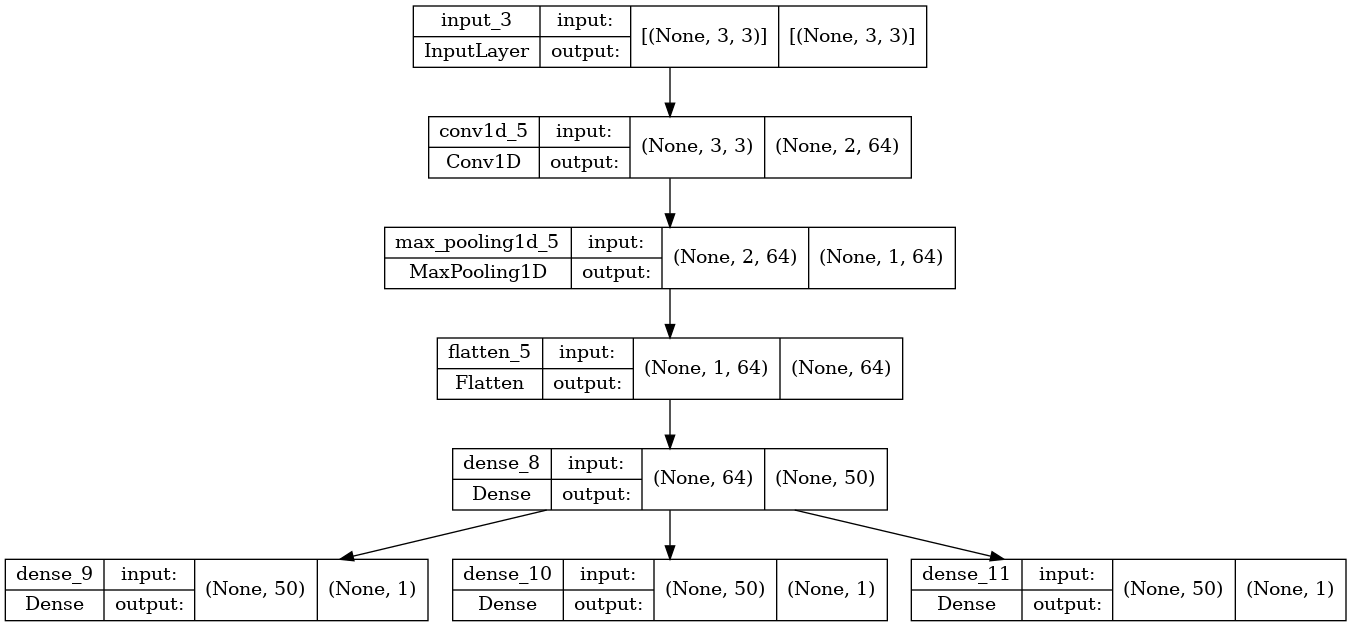

In [13]:
model = multiple_output_model(X, y, n_steps, n_features)
yhat = model.predict(x_input, verbose=0)
print(yhat)
plot_model(model, show_shapes=True)

# 3. Multi-sttep CNN models
Multi-step forecast model using a vector model

## 3.1. Vector Output model
The 1D CNN can output a vector directly that can be interpreted as a multi-step forecast.

This approach was seen in the previous section were one time step of each output time series was forecasted as a vector.

    [10 20 30] [40 50]
    [20 30 40] [50 60]
    [30 40 50] [60 70]
    [40 50 60] [70 80]
    [50 60 70] [80 90]

##### As using the 1D CNN model for univariate data, the CNN expects data to have a 3D structure. With the number of input and output steps specified in the n_steps_in and n_steps_out variables, we can define the multi-steps time series forecasting model 

In [14]:
# define multiple outputs model
def vector_output_model(X, y, n_steps_in, n_steps_out, n_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=2000, verbose=0)
    return model

In [15]:
## prepare dataset for training and testing set
def split_vector_output(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        ix = i + n_steps_in
        out = ix + n_steps_out
        if out > len(sequences):
            break
        seqx, seqy = sequences[i:ix], sequences[ix:out]
        X.append(seqx)
        y.append(seqy)
    return np.array(X), np.array(y)

# choose steps_in, steps_out
n_steps_in, n_steps_out = 3, 2
X, y = split_vector_output(raw_seq, n_steps_in, n_steps_out)
print(X.shape, y.shape)

(5, 3) (5, 2)


In [16]:
# CNN expects data to have 3-dimensional structure [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# demonstrate prediction
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))


In [17]:
model = vector_output_model(X, y, n_steps_in, n_steps_out, n_features)
yhat = model.predict(x_input, verbose=0)

print(yhat)

[[103.85263  115.899635]]


## 3.2. Multiple Input Multi-step Output
There are those multivariate time series forecasting problems where the output series is separate but dependent upon the input time series, and multiple time steps are required for the output series.

In [20]:
## prepare data
def split_multivariate_multistep_output(sequences, n_step_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        ix = i + n_steps_in
        out = ix + n_steps_out - 1
        if out > len(sequences):
            break
        seqx, seqy = sequences[i:ix, :-1], sequences[ix-1:out, -1]
        X.append(seqx)
        y.append(seqy)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 3, 2
X, y = split_multivariate_multistep_output(sequences, n_steps_in, n_steps_out)
print(X.shape, y.shape)
print(X[0], y[0])

(6, 3, 2) (6, 2)
[[10 15]
 [20 25]
 [30 35]] [65 85]


In [21]:
n_features = X.shape[2]
model = vector_output_model(X, y, n_steps_in, n_steps_out, n_features)

[[185.48633 207.40816]]


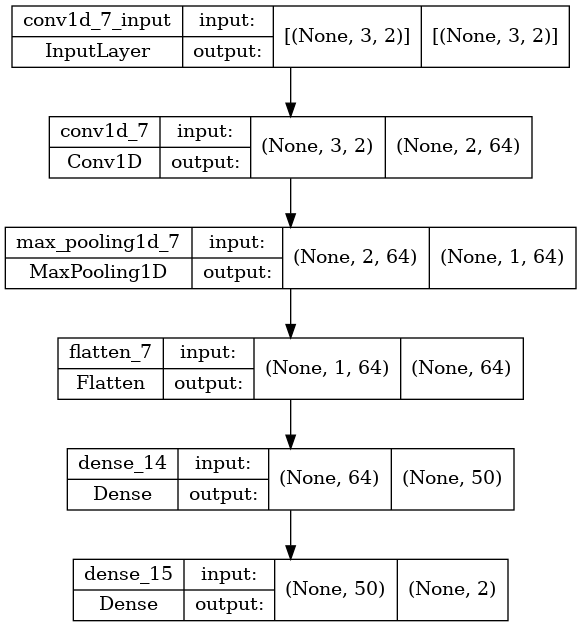

In [23]:
# demonstrate prediction
x_input = np.array([[70, 75], [80, 85], [90, 95]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)
plot_model(model, show_shapes=True)

## 3.2 Multiple Parallel Input and Multi-step Output
A problem with parallel time series may require the prediction of multiple time steps of each time series.

Input

    10, 15, 25
    20, 25, 45
    30, 35, 65

Output

    40, 45, 85
    50, 55, 105

In [27]:
def split_multi_prallel_multi_step_out(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        ix = i + n_steps_in
        out = ix + n_steps_out
        if out > len(sequences):
            break
        seqx, seqy = sequences[i:ix, :], sequences[ix:out, :]
        X.append(seqx)
        y.append(seqy)
    return np.array(X), np.array(y)

X, y = split_multi_prallel_multi_step_out(sequences, n_steps_in, n_steps_out)
print(X.shape, y.shape)

(5, 3, 3) (5, 2, 3)


In [28]:
# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
print(y.shape, y[0])

(5, 6) [ 40  45  85  50  55 105]


In [29]:
## define model 
n_features = X.shape[2]

def parallel_in_multistep_out_model(X, y, n_steps_in, n_output, n_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=3000, verbose=0)
    return model

In [30]:
model = parallel_in_multistep_out_model(X, y, n_steps_in, n_output, n_features)

In [32]:
# demonstrate prediction
x_input = np.array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 90.65258   96.07465  187.14441  101.25422  107.215416 208.43105 ]]
